In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add the absolute path to the src directory to sys.path
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)


Null values per column:
timestamp           0
side                0
price               0
size                0
number_of_orders    0
dtype: int64

Shape after dropping nulls: (130500, 5)

Shape after dropping duplicates: (130500, 5)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130500 entries, 0 to 130499
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         130500 non-null  datetime64[ns]
 1   side              130500 non-null  category      
 2   price             130500 non-null  float32       
 3   size              130500 non-null  float32       
 4   number_of_orders  130500 non-null  int16         
dtypes: category(1), datetime64[ns](1), float32(2), int16(1)
memory usage: 2.4 MB

Descriptive Statistics:
                            timestamp    side          price           size  \
count                          130500  130500  130500.000000  130500

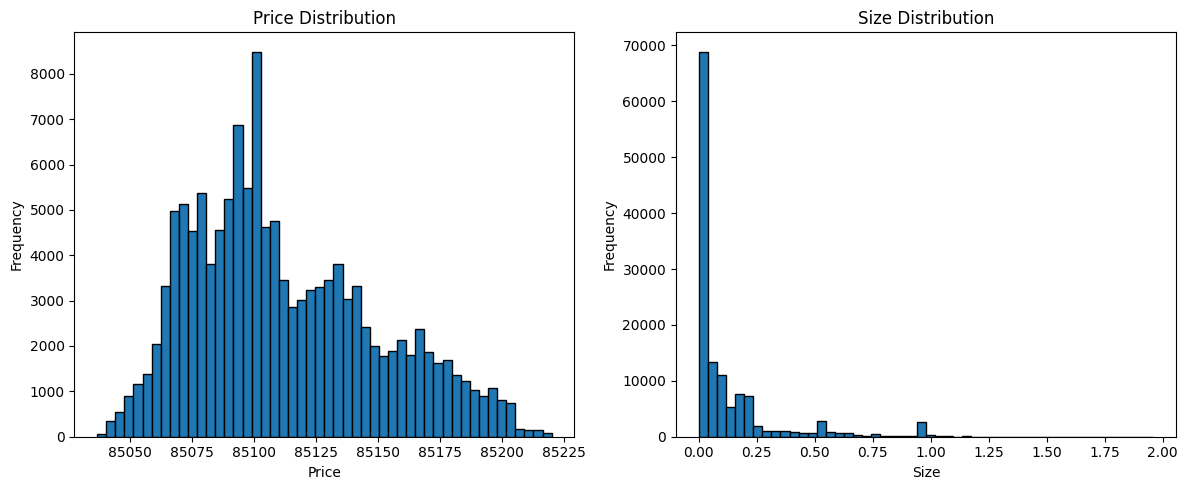


Average values by order side:
             price      size  number_of_orders
side                                          
ask   85124.265625  0.122629          1.475249
bid   85099.843750  0.123428          1.401027


/var/folders/5w/ldj158n56hqdrfyxyzypf75w0000gp/T/ipykernel_41246/145788891.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_by_side = df_clean.groupby('side')[['price', 'size', 'number_of_orders']].mean()


In [11]:
# Define data types to reduce memory usage
dtype_dict = {
    'timestamp': 'float64',          # Original timestamp in epoch seconds
    'side': 'category',              # Few unique values (e.g., 'bid', 'ask')
    'price': 'float32',              # Prices as float32 for less memory usage
    'size': 'float32',               # Sizes as float32
    'number_of_orders': 'int16'      # Small integer for order counts
}

# Load the CSV with the defined dtypes
df = pd.read_csv('data/reconstructed_orderbook_small.csv', dtype=dtype_dict)

# --- Data Cleaning ---
# 1. Check for null values in each column
print("Null values per column:")
print(df.isnull().sum())

# 2. Drop rows with any null values (if any exist)
df_clean = df.dropna()
print("\nShape after dropping nulls:", df_clean.shape)

# 3. Convert 'timestamp' from epoch seconds to datetime
#    This assumes that the timestamp is in seconds. Adjust `unit` if needed.
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], unit='s')

# 4. Drop duplicate rows if there are any
df_clean = df_clean.drop_duplicates()
print("\nShape after dropping duplicates:", df_clean.shape)

# --- Exploratory Data Analysis ---
# A. Display basic info and descriptive statistics
print("\nDataFrame Info:")
df_clean.info()
print("\nDescriptive Statistics:")
print(df_clean.describe(include='all'))

# B. Check the distribution of categorical column 'side'
print("\nValue counts for 'side':")
print(df_clean['side'].value_counts())

# C. Plot histograms for numerical columns (price and size)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Price distribution histogram
ax[0].hist(df_clean['price'], bins=50, edgecolor='black')
ax[0].set_title('Price Distribution')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

# Size distribution histogram
ax[1].hist(df_clean['size'], bins=50, edgecolor='black')
ax[1].set_title('Size Distribution')
ax[1].set_xlabel('Size')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# D. Optional: Analyze orders based on side (if you have both 'bid' and 'ask' values)
if 'ask' in df_clean['side'].cat.categories and 'bid' in df_clean['side'].cat.categories:
    summary_by_side = df_clean.groupby('side')[['price', 'size', 'number_of_orders']].mean()
    print("\nAverage values by order side:")
    print(summary_by_side)


In [12]:
df.head(10)

,timestamp,side,price,size,number_of_orders
0,1.744730e+09,bid,85188.296875,0.668927,11
1,1.744730e+09,bid,85188.203125,0.000010,1
2,1.744730e+09,bid,85188.000000,0.022900,1
3,1.744730e+09,bid,85184.398438,0.033631,1
4,1.744730e+09,bid,85184.000000,0.022900,1
5,1.744730e+09,bid,85182.500000,0.086821,1
6,1.744730e+09,bid,85182.398438,0.193500,1
7,1.744730e+09,bid,85182.203125,0.002040,1
8,1.744730e+09,bid,85182.000000,0.098981,2
9,1.744730e+09,bid,85180.500000,0.014071,1


# Visualize the orderbook over time

In [8]:
# Import functions and libraries
from src.francis.orderbook_plot import plot_orderbook_over_time
from src.francis.orderbook_reconstruction import reconstruct_orderbook_every_tick_with_orders
import pandas as pd
import json

In [9]:
# Reconstruct the orderbook
# Reload the uploaded original CSV file
file_path = "data/orderbook_data.csv"
df = pd.read_csv(file_path, header=None)

# Assign column names
df.columns = ["timestamp", "side", "price", "size", "number_of_orders"]
df = df[df["side"].isin(["bid", "ask"])]
df["timestamp"] = df["timestamp"].astype(float)
df["price"] = df["price"].astype(float)
df["size"] = df["size"].astype(float)

# Sort by timestamp
df = df.sort_values(by="timestamp")


# The original data is too large to visualize, so we take a sample
df_small = df.head(100000)
sample_orderbook, sample_csv_rows = reconstruct_orderbook_every_tick_with_orders(
    df_small
)

# Save the result to JSON
sample_json_path = "data/reconstructed_orderbook_small.json"
with open(sample_json_path, "w") as f:
    json.dump(sample_orderbook, f)

# Save the result to CSV
sample_df = pd.DataFrame(
    sample_csv_rows, columns=["timestamp", "side", "price", "size", "number_of_orders"]
)

sample_df.to_csv("data/reconstructed_orderbook_small.csv", index=False)




/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_31821/381855110.py:4: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=None)


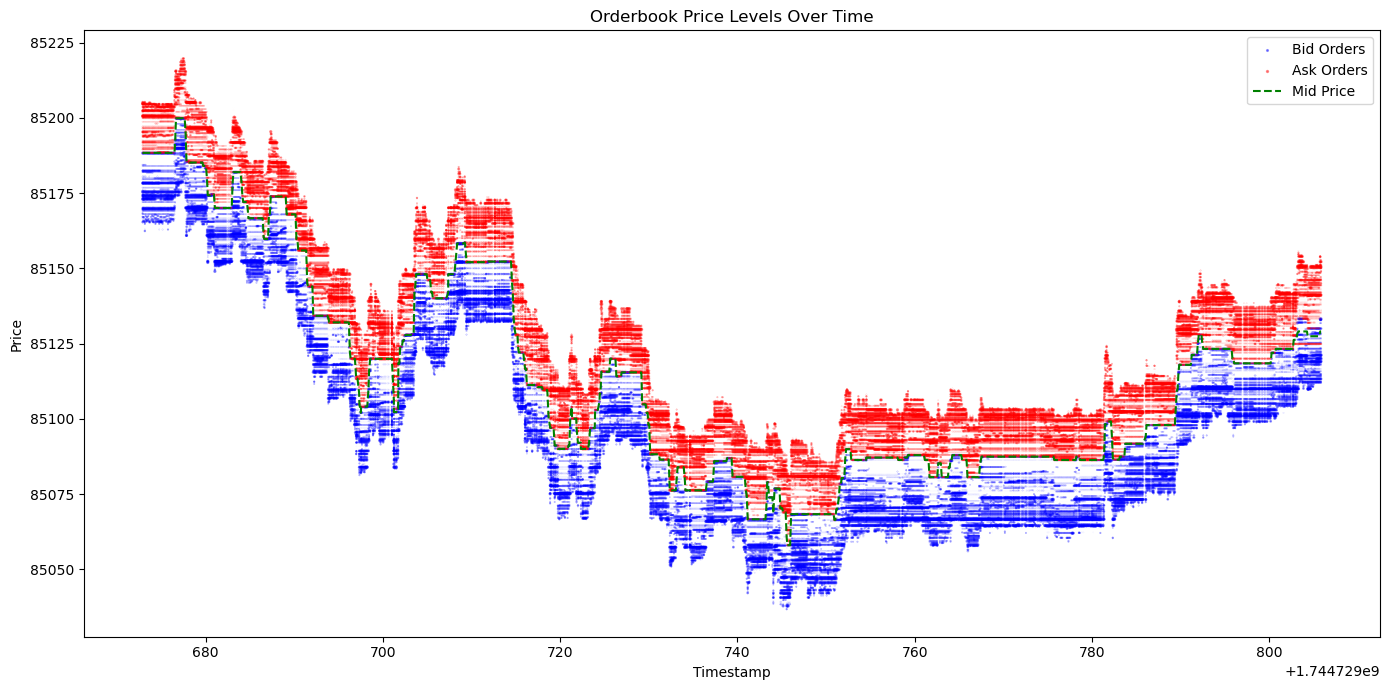

In [10]:

orderbook = pd.read_csv("data/reconstructed_orderbook_small.csv")
plot_orderbook_over_time(orderbook)
